In [10]:
import pandas as pd
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Читаем данные
df = pd.read_csv('data_task4_old.txt', sep='\t', 
    dtype={
    'tid':'Int64',
    'Microtasks':'Int64',
    'assigned_ts':'str',
    'closed_ts':'str',
    },
    parse_dates=[
    'assigned_ts',
    'closed_ts',
    ])

#Считаем сколько секунд занимает один микротаск
df['time_for_microtask'] = (df['closed_ts'] - df['assigned_ts']).dt.total_seconds() / df['Microtasks']
#Смотрим статистику
df['time_for_microtask'].describe()

count    7.018270e+05
mean     5.681515e+02
std      5.378995e+03
min     -7.290000e+02
25%      3.700000e+01
50%      7.500000e+01
75%      1.820000e+02
max      1.074156e+06
Name: time_for_microtask, dtype: float64

Минимум минус 7290 секунд. Видимо есть баг, нужно найти область где начинаются реалистичные значения
Также не навится 75й прецентиль - слишком сильно отличается от медианы
Посмотрим числовую гистограмму (прецентили)

In [3]:
#Cмотрим распределение (нечётные прецентили, т.к. head показывает только 60 результатов)
df['time_for_microtask'].quantile([i/100 for i in range(1,100,2)]).head(50)

0.01       9.250000
0.03      13.000000
0.05      15.800000
0.07      18.000000
0.09      20.000000
0.11      22.125000
0.13      24.250000
0.15      26.300000
0.17      28.400000
0.19      30.500000
0.21      32.666667
0.23      35.000000
0.25      37.000000
0.27      39.000000
0.29      41.800000
0.31      44.000000
0.33      46.666667
0.35      49.000000
0.37      52.000000
0.39      55.000000
0.41      58.000000
0.43      61.500000
0.45      65.000000
0.47      69.000000
0.49      73.000000
0.51      77.000000
0.53      81.500000
0.55      86.375000
0.57      92.000000
0.59      98.000000
0.61     104.200000
0.63     111.534069
0.65     119.800000
0.67     129.000000
0.69     139.000000
0.71     151.000000
0.73     165.000000
0.75     182.000000
0.77     201.286667
0.79     225.500000
0.81     256.000000
0.83     294.350909
0.85     345.000000
0.87     417.000000
0.89     518.000000
0.91     675.000000
0.93     941.000000
0.95    1542.000000
0.97    3314.355000
0.99    8945.333143


Попробуем посмотреть статиску по пользователям, убрав явный мусор - значения ниже первого перцентеля и значения выше 5 медиан
Исхожу из гипотезы, что все микрозадания однородны
Также, очевидно из-за высоких значений на верхних прецентилях медиана смещена (это может быть из-за технических причин, а может быть так часто уходят пить чай; причины требуют дополнительного исследования и дополнительных данных)

In [4]:
descriptions = df[(df['time_for_microtask'] > 15) &\
    (df['time_for_microtask'] < 75*5)].groupby('login')\
        ['time_for_microtask'].describe()

In [5]:
descriptions

,count,mean,std,min,25%,50%,75%,max
login,,,,,,,,
login0,510.0,109.911234,97.000092,15.000000,28.083333,68.666667,185.625000,374.666667
login1,932.0,117.233307,77.202981,15.222222,58.187500,96.000000,155.400000,368.500000
login10,36.0,88.033796,69.567713,19.666667,43.000000,65.000000,107.975000,286.000000
login100,13.0,130.972436,105.862101,30.000000,56.375000,88.500000,180.000000,373.500000
login101,2123.0,85.658651,70.360451,15.055556,38.800000,61.600000,105.766667,374.000000
...,...,...,...,...,...,...,...,...
login95,1581.0,62.547212,49.722168,15.000000,32.000000,47.000000,73.000000,371.000000
login96,41.0,52.945664,41.097302,16.500000,25.000000,38.500000,65.000000,189.000000
login97,231.0,176.678329,95.547110,19.400000,99.000000,160.000000,253.750000,372.333333


Большой размах разнообразия подсказывает, что пользователи выполняют разные работы. То есть скорее всего сами микротаски не однородны, не одинаковы, физически требуют разного времени на выполнение

Для хорошего вывода необходимо также учесть тип микротаска (например, разметка изображения или ввод текста с изображения или ввод текста из аудио и т.д.) и оценивать необходимое время уже исходя из этого

Предположим, что данные которые у нас есть - всё чем мы можем предполагать и продолжим

In [6]:
descriptions[descriptions['count']>100]['50%'].describe()

count    550.000000
mean      88.844678
std       37.741439
min       25.000000
25%       61.000000
50%       82.398810
75%      112.321429
max      246.000000
Name: 50%, dtype: float64

Медиана медианного времени пользователей, сделавших более 100 заданий 82.4
Близка к начальной медиане

<AxesSubplot:xlabel='50%'>

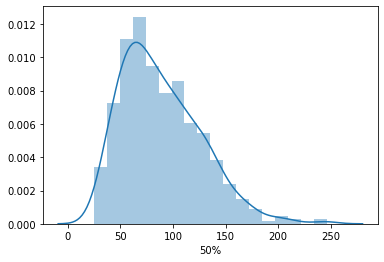

In [30]:
sns.distplot(descriptions[descriptions['count']>100]['50%'])

Распределение не пугающе отличается от нормального
Тем не менее, медианное время смещено влево
Возможно, всё-таки пользователи выполняют сущностно разные работы (на предоставленных данных невозможно проверить)
Обращает внимание мода в районе 70 секунд